In [69]:
import re

import numpy as np
import optuna as opt
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

In [27]:
random_id = 17 #ai23m017 - 17 is the id
random_state = np.random.RandomState(random_id)

In [28]:
to_test = pd.read_csv("test.csv", index_col="PassengerId")
df = pd.read_csv("train.csv", index_col="PassengerId")
df

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,S


In [29]:
df = df.convert_dtypes()
df["Embarked"] = df["Embarked"].astype("category")
df.dtypes

Survived             Int64
Pclass               Int64
Name        string[python]
Age                Float64
SibSp                Int64
Parch                Int64
Ticket      string[python]
Fare               Float64
Cabin       string[python]
Embarked          category
dtype: object

In [30]:
'''
random_id = 17 #ai23m017 - 17 is the id
# a RandomState object or the id may be used, choose a variant
random_state = np.random.RandomState(random_id)
random_state = random_id
'''
#TODO implement this for all random states

'\nrandom_id = 17 #ai23m017 - 17 is the id\n# a RandomState object or the id may be used, choose a variant\nrandom_state = np.random.RandomState(random_id)\nrandom_state = random_id\n'

In [31]:
X_train,X_test,y_train,y_test = train_test_split(df.drop("Survived", axis=1), df["Survived"], test_size=0.2, random_state=random_id)
print(df.columns[df.isna().any(axis=0)].tolist())

['Age', 'Cabin', 'Embarked']


### Data Pre-Processing after splitting the data to prevent data - leakage

In [32]:
#Data Imputation for the Age column
data = [X_train, X_test, to_test]
for dataset in data:
    mean = X_train["Age"].mean()
    std = X_test["Age"].std()
    is_null = dataset["Age"].isna().sum()
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    rand_age_series = pd.Series(rand_age, index=dataset[dataset["Age"].isnull()].index)
    dataset["Age"].fillna(rand_age_series, inplace=True)
    dataset["Age"] = dataset["Age"].astype(int)
    

In [33]:
#Feature Engineering the Deck Column 
#Cabins are mapped to a numerical Deck feature

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    dataset.drop(["Cabin"], axis=1, inplace=True)

In [34]:
X_train["Embarked"].describe()
for dataset in [X_train, X_test, to_test]:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)


In [35]:
X_train.isna().any()

Pclass      False
Name        False
Age         False
SibSp       False
Parch       False
Ticket      False
Fare        False
Embarked    False
Deck        False
dtype: bool

In [36]:
#Feature Engineering Title Column
for dataset in data:
    dataset["Title"] = dataset["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())

In [37]:
#Feature Engineering Sex Column 
def map_to_sex(value):
    if value in ["Miss","Mrs"]:
        return "female"
    else:
        return "male"

for dataset in data:
    dataset["Sex"] = dataset["Title"].apply(map_to_sex)
    dataset.drop("Title", axis=1, inplace=True)

In [38]:
#Feature Engineering Family Size Column
for dataset in data:
    dataset["Fam_size"] = dataset["SibSp"] + dataset["Parch"] + 1
    dataset["Fam_type"] = pd.cut(dataset.Fam_size, [0,1,4,7,11], labels=["Solo", "Small", "Big", "Very big"])
    dataset.drop(["SibSp","Parch"], axis=1, inplace=True)


In [39]:
for dataset in data:
    ticket_frequency = dataset.groupby('Ticket')['Name'].transform('count')
    dataset['Ticket_Frequency'] = ticket_frequency

In [40]:

for dataset in data:
    dataset['Age*Class'] = dataset['Age'] * dataset['Pclass']
    dataset.drop(columns=["Age","Pclass"], inplace=True)

In [41]:
#Feature Engineering Ticket_2letter column
for dataset in data:
    '''
    dataset["Ticket_2letter"] = dataset.Ticket.apply(lambda x: x[:2])
    dataset["Ticket_len"] = dataset.Ticket.apply(lambda x: len(x))
    dataset["Cabin_num"] = dataset.Ticket.apply(lambda x: len(x.split()))
    dataset["Cabin_1letter"] = dataset.Ticket.apply(lambda x: x[:1])
    '''
    dataset.drop("Ticket", axis=1, inplace=True)

In [42]:
for dataset in data:
    dataset['Fare'] = np.log1p(dataset['Fare'])
    dataset['Fare_Per_Person'] = dataset['Fare'] / (dataset['Fam_size'])
    dataset['Fare_Bin'] = pd.qcut(dataset['Fare'], 4, labels=False)
    


In [43]:
X_train

,Name,Fare,Embarked,Deck,Sex,Fam_size,Fam_type,Ticket_Frequency,Age*Class,Fare_Per_Person,Fare_Bin
PassengerId,,,,,,,,,,,
874,"Vander Cruyssen, Mr. Victor",2.302585,S,8,male,1,Solo,1,141,2.302585,1
829,"McCormack, Mr. Thomas Joseph",2.169054,Q,8,male,1,Solo,1,54,2.169054,0
100,"Kantor, Mr. Sinai",3.295837,S,8,male,2,Small,2,68,1.647918,2
524,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",4.077185,C,2,female,2,Small,2,44,2.038592,3
133,"Robins, Mrs. Alexander A (Grace Charity Laury)",2.74084,S,8,female,2,Small,1,141,1.37042,2
...,...,...,...,...,...,...,...,...,...,...,...
407,"Widegren, Mr. Carl/Charles Peter",2.169054,S,8,male,1,Solo,1,153,2.169054,0
391,"Carter, Mr. William Ernest",4.795791,S,2,male,4,Small,3,36,1.198948,3
144,"Burke, Mr. Jeremiah",2.047693,Q,8,male,1,Solo,1,57,2.047693,0


In [44]:
port_survival_mapping = {'S': 0.33, 'C': 0.55, 'Q': 0.39}
for dataset in data:
    dataset['Embarked_Survival_Rate'] = dataset['Embarked'].map(port_survival_mapping)  
    #average_fare_per_port = dataset.groupby('Embarked')['Fare'].mean().to_dict()
    #dataset['Avg_Fare_Per_Port'] = dataset['Embarked'].map(average_fare_per_port)
    dataset.drop(columns=["Fare","Fam_size"],axis=1,inplace=True)
    

In [45]:
X_train

,Name,Embarked,Deck,Sex,Fam_type,Ticket_Frequency,Age*Class,Fare_Per_Person,Fare_Bin,Embarked_Survival_Rate
PassengerId,,,,,,,,,,
874,"Vander Cruyssen, Mr. Victor",S,8,male,Solo,1,141,2.302585,1,0.33
829,"McCormack, Mr. Thomas Joseph",Q,8,male,Solo,1,54,2.169054,0,0.39
100,"Kantor, Mr. Sinai",S,8,male,Small,2,68,1.647918,2,0.33
524,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",C,2,female,Small,2,44,2.038592,3,0.55
133,"Robins, Mrs. Alexander A (Grace Charity Laury)",S,8,female,Small,1,141,1.37042,2,0.33
...,...,...,...,...,...,...,...,...,...,...
407,"Widegren, Mr. Carl/Charles Peter",S,8,male,Solo,1,153,2.169054,0,0.33
391,"Carter, Mr. William Ernest",S,2,male,Small,3,36,1.198948,3,0.33
144,"Burke, Mr. Jeremiah",Q,8,male,Solo,1,57,2.047693,0,0.39


### Encode all Labels to String in order to pass through the GBM model

In [46]:
X_train = X_train.apply(LabelEncoder().fit_transform)
X_test = X_test.apply(LabelEncoder().fit_transform)
to_test = to_test.apply(LabelEncoder().fit_transform)
X_train

,Name,Embarked,Deck,Sex,Fam_type,Ticket_Frequency,Age*Class,Fare_Per_Person,Fare_Bin,Embarked_Survival_Rate
PassengerId,,,,,,,,,,
874,672,2,7,1,2,0,97,186,1,0
829,413,1,7,1,2,0,49,156,0,1
100,333,2,7,1,1,1,61,109,2,0
524,286,0,1,0,1,1,39,127,3,2
133,564,2,7,0,1,0,97,83,2,0
...,...,...,...,...,...,...,...,...,...,...
407,690,2,7,1,2,0,101,156,0,0
391,107,2,1,1,1,2,31,68,3,0
144,85,1,7,1,2,0,52,128,0,1


### Cross-Fold Validation

In [47]:
xgb_classifier = XGBClassifier() # classifier used to tune hyperparameters

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',  # or 'multi:softprob' for multiclass and set 'num_class'
        'eval_metric': 'logloss',  # or another suitable metric
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100.0),
    }

    model = xgb.XGBClassifier(**param)
    
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    return scores.mean()


In [48]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-03-12 18:40:48,226] A new study created in memory with name: no-name-84e75b48-68c2-4c8f-9391-0004dc15f0da
[I 2024-03-12 18:40:50,910] Trial 0 finished with value: 0.8145868216290753 and parameters: {'learning_rate': 0.18988478271780299, 'n_estimators': 752, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8276758036348424, 'colsample_bytree': 0.7116144098940449, 'reg_alpha': 0.6671192617028393, 'reg_lambda': 44.35428707853075}. Best is trial 0 with value: 0.8145868216290753.
[I 2024-03-12 18:40:52,470] Trial 1 finished with value: 0.817393873731902 and parameters: {'learning_rate': 0.2874102372908826, 'n_estimators': 551, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8133560324446518, 'colsample_bytree': 0.7095984556973685, 'reg_alpha': 0.6480423228850077, 'reg_lambda': 33.2329303477287}. Best is trial 1 with value: 0.817393873731902.
[I 2024-03-12 18:40:55,492] Trial 2 finished with value: 0.8300403821530583 and parameters: {'learning_rate': 0.016745376654402774, 

Number of finished trials: 100
Best trial: {'learning_rate': 0.14726907732045363, 'n_estimators': 448, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.688630720853024, 'colsample_bytree': 0.5852534505966063, 'reg_alpha': 0.33122358675211105, 'reg_lambda': 67.7056621126361}


In [49]:
best_trial = study.best_trial
print(f"Best trial accuracy: {best_trial.value}")

Best trial accuracy: 0.8356446370530879


### Generate Results

In [50]:
xgb_classifier.set_params(**best_trial.params)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5852534505966063, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14726907732045363,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=448, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [51]:
y_pred = xgb_classifier.predict(X_test)

In [52]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.77


In [53]:
submission_test = xgb_classifier.predict(to_test)
submission_test = pd.Series(submission_test, to_test.index, name='Survived')
# save submission
#submission_test.to_csv('submission_test.csv') 

In [54]:
actual_data = pd.read_csv("test_results.csv",index_col="PassengerId")
merged_df = pd.merge(actual_data, submission_test, on='PassengerId', suffixes=('_df1', '_df2'))
# Step 3: Calculate accuracy score
accuracy = accuracy_score(merged_df['survived'], merged_df['Survived'])

print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.7713567839195979


In [55]:
merged_df

,survived,Survived
PassengerId,,
892,0.0,0
892,0.0,0
893,1.0,0
894,0.0,0
895,0.0,0
...,...,...
1305,0.0,0
1306,1.0,0
1307,0.0,0


In [67]:
results = permutation_importance(xgb_classifier, X_test, y_test, scoring='accuracy')
results

{'importances_mean': array([-0.00223464, -0.00670391,  0.00893855,  0.08715084,  0.00111732,
        -0.00670391,  0.04581006,  0.00782123, -0.00782123, -0.01117318]),
 'importances_std': array([0.01523819, 0.00651503, 0.01439564, 0.0139553 , 0.00651503,
        0.00651503, 0.02813336, 0.01986189, 0.00757802, 0.00790063]),
 'importances': array([[-0.01117318,  0.02234637,  0.00558659, -0.00558659, -0.02234637],
        [-0.00558659, -0.01117318, -0.01675978,  0.        ,  0.        ],
        [ 0.00558659,  0.02234637, -0.01675978,  0.02234637,  0.01117318],
        [ 0.10055866,  0.06145251,  0.09497207,  0.09497207,  0.08379888],
        [ 0.        ,  0.01117318, -0.00558659,  0.00558659, -0.00558659],
        [-0.00558659, -0.01117318, -0.01675978,  0.        ,  0.        ],
        [ 0.05586592,  0.0726257 , -0.00558659,  0.06703911,  0.03910615],
        [-0.02234637,  0.01117318,  0.03351955,  0.02234637, -0.00558659],
        [-0.00558659,  0.00558659, -0.01675978, -0.01117318,

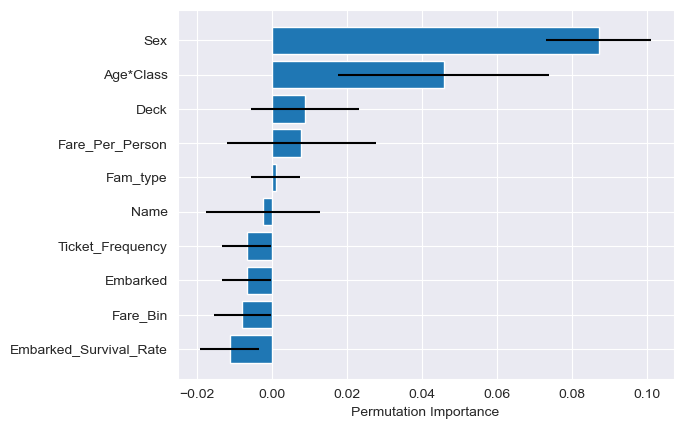

In [70]:
importance = results.importances_mean
std = results.importances_std

features = X_train.columns
sorted_idx = importance.argsort()

plt.barh(range(len(sorted_idx)), importance[sorted_idx], xerr=std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

## RandomForestClassifier

In [57]:
from sklearn.ensemble import RandomForestClassifier


def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    model = RandomForestClassifier(**param, random_state=random_id)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    return accuracy

In [58]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print(f"Best trial accuracy: {study.best_trial.value}")

[I 2024-03-12 18:43:44,685] A new study created in memory with name: no-name-31148744-2b54-4ea6-9ac8-2379880d5c78
[I 2024-03-12 18:43:46,396] Trial 0 finished with value: 0.776536312849162 and parameters: {'n_estimators': 664, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.776536312849162.
[I 2024-03-12 18:43:46,931] Trial 1 finished with value: 0.7877094972067039 and parameters: {'n_estimators': 186, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.7877094972067039.
[I 2024-03-12 18:43:47,838] Trial 2 finished with value: 0.776536312849162 and parameters: {'n_estimators': 325, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.7877094972067039.
[I 2024-03-12 18:43:52,928] Trial 3 finished with value: 0.7374301675977654 

Number of finished trials: 100
Best trial: {'n_estimators': 186, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}
Best trial accuracy: 0.7877094972067039


In [59]:
randomForest_classifier = RandomForestClassifier()
randomForest_classifier.set_params(**study.best_trial.params)
randomForest_classifier.fit(X_train, y_train)
y_pred = randomForest_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.78


### Compare accuracy to supposed real data

In [60]:
submission_test = randomForest_classifier.predict(to_test)
submission_test = pd.Series(submission_test, to_test.index, name='Survived')
actual_data = pd.read_csv("test_results.csv",index_col="PassengerId")
merged_df = pd.merge(actual_data, submission_test, on='PassengerId', suffixes=('_df1', '_df2'))
# Step 3: Calculate accuracy score
accuracy = accuracy_score(merged_df['survived'], merged_df['Survived'])

print(f"Accuracy Score: {accuracy}")


Accuracy Score: 0.7562814070351759


In [61]:
to_test.columns

Index(['Name', 'Embarked', 'Deck', 'Sex', 'Fam_type', 'Ticket_Frequency',
       'Age*Class', 'Fare_Per_Person', 'Fare_Bin', 'Embarked_Survival_Rate'],
      dtype='object')

### Try out ensemble of different models

In [62]:
stacking_clf = StackingClassifier(
    estimators=[('rf', randomForest_classifier), ('xgb', xgb_classifier)],
    final_estimator=LogisticRegression(),
    stack_method='auto',
    cv=10
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=23,
                                                       min_samples_leaf=10,
                                                       min_samples_split=4,
                                                       n_estimators=186)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5852534505966063,
                                              early_stopping_rounds=None,
                                              enable_categorical=Fals...
                                              interaction_constraints=None,
                                              learning_rate=0.14726907732045363,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=3, missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=448, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression())

In [63]:
accuracy = stacking_clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7932960893854749


In [64]:
submission_test = stacking_clf.predict(to_test)
submission_test = pd.Series(submission_test, to_test.index, name='Survived')
actual_data = pd.read_csv("test_results.csv",index_col="PassengerId")
merged_df = pd.merge(actual_data, submission_test, on='PassengerId')
# Step 3: Calculate accuracy score
accuracy = accuracy_score(merged_df['survived'], merged_df['Survived'])

print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.7562814070351759


In [65]:
submission_test.to_csv("submission_test2.csv")

In [66]:
X_train.columns.to_list()

['Name',
 'Embarked',
 'Deck',
 'Sex',
 'Fam_type',
 'Ticket_Frequency',
 'Age*Class',
 'Fare_Per_Person',
 'Fare_Bin',
 'Embarked_Survival_Rate']